# Customer Segmentation & Profiling
As a Behavioral Data Scientist, the project focuses on identifying customer behavior patterns within a UK online gift retailer’s transaction data using RFM metrics and K-Means clustering to inform personalized marketing strategies.

#### Goal
Identify and group customers based on their purchase behavior using unsupervised machine learning techniques, then interpret each cluster through a **behavioral psychology lens** to inform marketing decisions.

*An e-commerce dataset containing transactions from 2010 and 2011 from a UK-based online retailer will be used*


# Table of Contents

1. [Data Understanding](#1-data-understanding)  
   *Overview of dataset structure, columns, and sample exploration.*

2. [Data Cleaning & Preparation](#2-data-cleaning--preparation)  
   *Handling missing values, dropping columns, and filtering valid transactions.*

3. [RFM Feature Engineering](#3-rfm-feature-engineering)  
   *Calculation of Recency, Frequency, and Monetary metrics per customer.*

4. [Data Preprocessing for Clustering](#4-data-preprocessing-for-clustering)  
   *Log transformation and feature standardization to normalize scale.*

5. [K-Means Clustering](#5-k-means-clustering)  
   *Applying K-Means with Elbow and Silhouette methods for optimal k.*

6. [Behavioral, Psychological & Business Interpretation](#6-behavioral-psychological--business-interpretation)  
   *Explaining customer cluster behaviors, and segment meaning.*

7. [Visualization & Storytelling](#7-visualization--storytelling)  
   *Heatmap, bar plots, and visual insights summarizing customer segments.*

8. [Conclusion](#8-conclusion)  
   *Key findings.*

## 1. Data Understanding
First, let's explore and understand patterns within the dataset to get a clear mental picture.

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
df=pd.read_csv('ecommerce_data.csv', encoding='latin1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


The following columns include:
+ InvoiceNo - unique invoice number  
+ StockCode - is the product identifier
+ Description - product name or item description
+ Quantity - number of unit of that product that is purchased in that transaction
+ InvoiceDate - date & time of the transaction 
+ UnitPrice - price per unit of the product
+ CustomerID - unique customer id
+ Country - customer location

In [98]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


The **Quantity** variable shows significant variablity, with a mean of 9.55 and a high standard deviation of 218, indicating the presence of outliers or very large orders. The minimum value is in negative (-80,995), representing either a return or an error. Behavior can't be analyzed if returns stay in the dataset, thus it will be removed as it might distort findings; a customer might look like a low spender because he returned a big order.

The **'UnitPrice'** variable shows unrealistic negative values in the min, indicating an entry error. It will be investigated and will be filtered out later.

The **CustomerID** contains a lot of missing values (406,829 non-null), about a quarter of the transactions(exactly 135,080 missing records), suggesting that some purchases may have been made by unregistered or guest users. Missing ID's will likely be dropped later as we can't track the customer's behavior.

### **UnitPrice**
Let's investigate the -ve & 0 values in UnitPrices

In [99]:
(df['UnitPrice']==0).sum()

np.int64(2515)

In [100]:
print('Total numbers with UnitPrice =0:', (df['UnitPrice']==0).sum())
df[df['UnitPrice']==0]

Total numbers with UnitPrice =0: 2515


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,12/8/2011 13:58,0.0,NaN,United Kingdom
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,12/8/2011 13:58,0.0,NaN,United Kingdom
538554,581408,85175,NaN,20,12/8/2011 14:06,0.0,NaN,United Kingdom


In [101]:
df[df['UnitPrice']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


To ensure accurate calculation of customer behavior, 2515 transactions with **UnitPrice = 0** will be removed as they likely represent data entry errors or non-monetary transactions (like free samples).

### **Quantity**
Let's check the negative values

In [102]:
df[df['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


As seen above, the negative values in the **Quantity** ariables correspond to **InvoiceNo** entries that all begin with the letter **'C'**, indicating that these are cancelled transactions. Those are to be removed in the data cleaning procedure.

In [103]:
df.shape

(541909, 8)

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


The **Description** contains 540,455 non-null entries, meaning about 1,454 missing product descriptions. As mentioned before, missing values are also present in the **CustomerID** variable. These will need to be addressed during data cleaning. 

The **InvoiceDate** is stored as an object/string not a real timestamp. This will prevent us from correctly comparing it using correct chronological order. It will be converted to datetimes.

### **"Countries"**

In [105]:
print('all countries:', df['Country'].unique()) #all countries
print('Number of countries:', df['Country'].nunique()) #number of the countries
df['Country'].value_counts() #in order

all countries: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']
Number of countries: 38


Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


For the purpose of this analysis, the focus will be on the UK customer's only.

### Let's understand the business patterns in the dataset by answering the following questions:
1. Which products are sold most frequently?
2. Are there many small purchases or a few large ones?
3. Are most customers one-time buyers or repeat buyers?

#### **1. Which products are sold more frequently?**

In [106]:
top_products= (df.groupby(['StockCode', 'Description'])['Quantity']
               .sum()
               .sort_values(ascending=False)
               .head(10))
top_products

StockCode  Description                       
84077      WORLD WAR 2 GLIDERS ASSTD DESIGNS     53847
85099B     JUMBO BAG RED RETROSPOT               47363
84879      ASSORTED COLOUR BIRD ORNAMENT         36381
22197      POPCORN HOLDER                        36334
21212      PACK OF 72 RETROSPOT CAKE CASES       36039
85123A     WHITE HANGING HEART T-LIGHT HOLDER    35025
23084      RABBIT NIGHT LIGHT                    30680
22492      MINI PAINT SET VINTAGE                26437
22616      PACK OF 12 LONDON TISSUES             26315
21977      PACK OF 60 PINK PAISLEY CAKE CASES    24753
Name: Quantity, dtype: int64

In [107]:
#Let's check if any StockCodes have inconsistent descriptions (more than one)
inconsistent = (df.groupby('StockCode')['Description']
                .nunique()
                .reset_index()
                .query('Description > 1')
                )
print(inconsistent)


         StockCode  Description
1            10080            2
8            10133            2
26          15058A            2
28          15058C            2
31           16008            2
...            ...          ...
3972        90195A            2
4008        90210D            2
4043      DCGS0003            2
4050      DCGS0069            2
4065  gift_0001_20            2

[650 rows x 2 columns]


There are about 650 unique **StockCodes** that have more than one distinct **Description**. The top_products ranking might not be accurate because if a StockCode has multiple names, you’ll see duplicates, more than one description.

Let's check some of the discrepancies further:

In [108]:
df[df['StockCode']=='10080']['Description'].unique()

array(['GROOVY CACTUS INFLATABLE', nan, 'check'], dtype=object)

In [109]:
df[df['StockCode']=='10133']['Description'].unique()

array(['COLOURING PENCILS BROWN TUBE', 'damaged'], dtype=object)

In [110]:
df[df['StockCode']=='16008']['Description'].unique()

array(['SMALL FOLDING SCISSOR(POINTED EDGE)', 'check'], dtype=object)

In [111]:
df[df['StockCode']=='22197']['Description'].unique()

array(['SMALL POPCORN HOLDER', 'POPCORN HOLDER'], dtype=object)

In [112]:
df[df['StockCode']=='15058A']['Description'].unique()

array(['BLUE POLKADOT GARDEN PARASOL', nan, 'wet/rusty'], dtype=object)

In [113]:
df[df['StockCode']=='DCGS0069']['Description'].unique()

array(['OOH LA LA DOGS COLLAR', 'ebay'], dtype=object)

Most are *not real product sales* but bookkeeping entries. These *anomalies* will be handled later. 

For a more accurate representation of products, let's group by **StockCode** only and add a **Decsription**

In [114]:
top_ten=(df.groupby('StockCode')['Quantity']
         .sum()
         .sort_values(ascending=False)
         .head(10)
         )
top_ten

StockCode
22197     56450
84077     53847
85099B    47363
85123A    38830
84879     36221
21212     36039
23084     30646
22492     26437
22616     26315
21977     24753
Name: Quantity, dtype: int64

In [115]:
# add most frequent description to top_ten

def most_frequent_description(x):
    counts = x.value_counts()
    if len(counts) == 0:
        return None 
    else:
        return counts.index[0]

desc_map = (
    df.groupby('StockCode')['Description']
      .apply(most_frequent_description)
)
top_ten = top_ten.to_frame().join(desc_map)
print(top_ten)


           Quantity                         Description
StockCode                                              
22197         56450                      POPCORN HOLDER
84077         53847   WORLD WAR 2 GLIDERS ASSTD DESIGNS
85099B        47363             JUMBO BAG RED RETROSPOT
85123A        38830  WHITE HANGING HEART T-LIGHT HOLDER
84879         36221       ASSORTED COLOUR BIRD ORNAMENT
21212         36039     PACK OF 72 RETROSPOT CAKE CASES
23084         30646                  RABBIT NIGHT LIGHT
22492         26437             MINI PAINT SET VINTAGE 
22616         26315          PACK OF 12 LONDON TISSUES 
21977         24753  PACK OF 60 PINK PAISLEY CAKE CASES


#### **2. Are there many small purchases or a few large ones?**

Text(0, 0.5, 'Number of invoices')

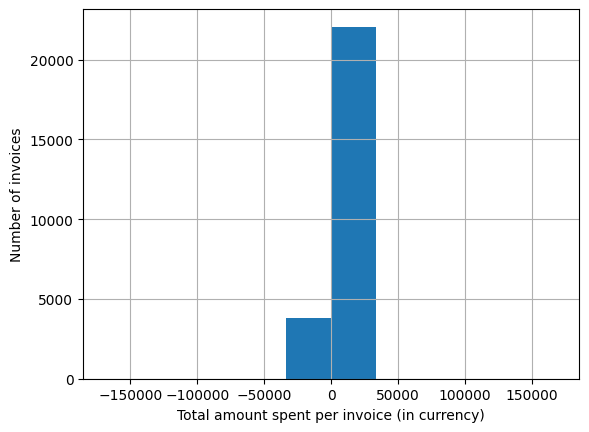

In [116]:
# Create a variable of total price
df['TotalPrice']=df['Quantity'] * df['UnitPrice']

#now groupby entire invoice (order) to understand the total spending per transaction 
ttl_invoice=df.groupby('InvoiceNo')['TotalPrice'].sum()

ttl_invoice.hist(bins=10)
plt.xlabel('Total amount spent per invoice (in currency)')
plt.ylabel('Number of invoices')


As seen, the invoice-level total spending distribution is extremely skewed, with extreme values on both positives and negatives. This indicates that the dataset includes a large number of many small transactions (tall bars), a few very large purchases, and negative totals indicating product returns or cancellations.

In [117]:
# numerical proof
ttl_invoice.describe()

count     25900.000000
mean        376.360924
std        2013.261050
min     -168469.600000
25%          11.775000
50%         207.535000
75%         409.085000
max      168469.600000
Name: TotalPrice, dtype: float64

#### **3. Are most customers one-time buyers or repeat buyers?**

In [118]:
#count how many unique invoices per customer
customers_orders= df.groupby('CustomerID')['InvoiceNo'].nunique()
customers_orders


CustomerID
12346.0     2
12347.0     7
12348.0     4
12349.0     1
12350.0     1
           ..
18280.0     1
18281.0     1
18282.0     3
18283.0    16
18287.0     3
Name: InvoiceNo, Length: 4372, dtype: int64

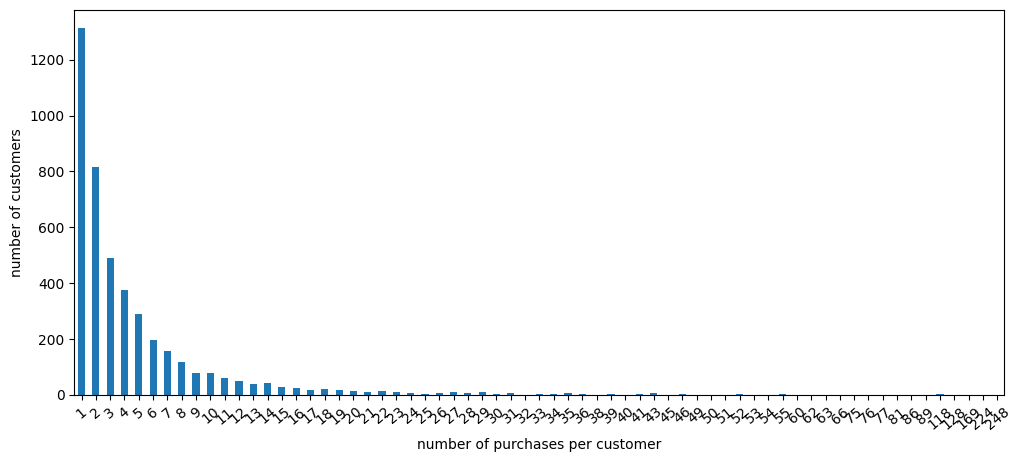

In [119]:
customers_orders.value_counts().sort_index().plot(kind='bar', figsize=(12,5))
plt.xlabel('number of purchases per customer')
plt.ylabel('number of customers')
plt.xticks(rotation=40)
plt.show()

As observed, most customers are one-time buyers, while a small number made multiple purchases. 

## 2. Data Cleaning & Preparation
Now let's clean and prepare the data, one variable at a time.

In [120]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice'],
      dtype='object')

### **1. Country**
For the purpose of this project, we'll eliminate transactions from non-UK countries. Why? UK customers form the majority of the dataset, contributing 495,478 out of 540,000, which is approximately 91% of the data. Furthermore, keeping the other countries might form clusters just because of region not of true behavioral patterns. To ensure homogeneity in customer behavior, only UK will be kept.

In [121]:
df= df[df['Country']=='United Kingdom'].copy()

In [122]:
df['Country'].value_counts() #confirm change

Country
United Kingdom    495478
Name: count, dtype: int64

### **2. InvoiceDate**
Let's convert date from object(strings) to datetime

In [123]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [124]:
#remove time
df['InvoiceDate'] = df['InvoiceDate'].dt.date

In [125]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [126]:
df['InvoiceDate'].head() #confirm change


0   2010-12-01
1   2010-12-01
2   2010-12-01
3   2010-12-01
4   2010-12-01
Name: InvoiceDate, dtype: datetime64[ns]

### **3. CustomerID**
Null CustomerID's will be dropped because we can't compute loyalty or recency without a customer identifier.


In [127]:
df['CustomerID'].isnull().sum()

np.int64(133600)

In [128]:
df.dropna(subset=['CustomerID'], axis=0, inplace=True)

In [129]:
df['CustomerID'].isnull().sum()

np.int64(0)

### **4. Invoice No**
The cancelled transactions will be removed. Simultaneously removing -ve values in **Quantity**.

In [130]:
df['InvoiceNo'].str.startswith('C').sum()

np.int64(7533)

In [131]:
df=df[~df['InvoiceNo'].str.startswith('C')]

In [132]:
df['InvoiceNo'].str.startswith('C').sum()

np.int64(0)

In [133]:
df[df['Quantity']<0] #let's confirm that -ve values in Quantity was also removed

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice


In [134]:
df[df['Quantity']==0] #or 0 Quantity

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice


### **5. UnitPrice**
Now the -ve & zero values in the **UnitPrice** will be dropped.

In [135]:
(df['UnitPrice']<0).sum()

np.int64(0)

The **UnitPrice** in negatives were removed as we cleansed the data above.

In [136]:
(df['UnitPrice']==0).sum()

np.int64(24)

In [137]:
df=df[df['UnitPrice']>0]

In [138]:
(df['UnitPrice']<=0).sum() # to confirm changes

np.int64(0)

### **6.Description**
The **Description** column will be dropped as it's not relevant for the behavioral analysis which is on a customer-level, not product-level. This column focuses on individual columns, whereas the RFM segmentation focuses on customer purchase level. But for future possible usages, a copy of the dataset will be kept with the **Description** to enable future product-level analysis, or in other words marketing/product exploration (word cloud visualization for example). 

In [139]:
df_products=df.copy() #Full backup for product analysis(with Description)

For customer segmentation, a simplified dataset will be created by removing the **Description**, focusing only on customer behavior metrics.

In [140]:
#RFM dataset (explanation later as to why this model was chosen)
df_rfm=df.drop(columns=['Description']).copy()

In [141]:
#For Confirmation
print("Original Cleaned dataset columns:", df.columns.tolist())
print("Products dataset columns:", df_products.columns.tolist())
print("RFM dataset columns:", df_rfm.columns.tolist())

Original Cleaned dataset columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalPrice']
Products dataset columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalPrice']
RFM dataset columns: ['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalPrice']


### **Last Checkup**
Let's check one last time the columns are correctly formatted

In [142]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 354321 entries, 0 to 541893
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354321 non-null  object        
 1   StockCode    354321 non-null  object        
 2   Description  354321 non-null  object        
 3   Quantity     354321 non-null  int64         
 4   InvoiceDate  354321 non-null  datetime64[ns]
 5   UnitPrice    354321 non-null  float64       
 6   CustomerID   354321 non-null  float64       
 7   Country      354321 non-null  object        
 8   TotalPrice   354321 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 27.0+ MB


perfect.

In [143]:
df_rfm.sample(5)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
449359,575117,22522,1,2011-11-08,0.85,12748.0,United Kingdom,0.85
290425,562377,84997B,1,2011-08-04,4.15,14535.0,United Kingdom,4.15
454164,575512,23570,12,2011-11-10,1.25,14121.0,United Kingdom,15.00
151095,549542,37446,32,2011-04-10,1.25,15311.0,United Kingdom,40.00
147535,549120,20725,4,2011-04-06,1.65,14587.0,United Kingdom,6.60


## 3. RFM Feature Engineering
Because we have the purchase date (**InvoiceDate**), number of purchases per customer(**InvoiceNo**), and total spending amount per transaction(**TotalPrice**), we can analyze the customer purchase behavior over time, thus the RFM (Recency, Frequency, Monetary) model will be conducted.
The dataset should be reshaped into a form where each row represents one customer. And the following three columns will be changed to derive the RFM features:
+ InvoiceDate = used to calculate **Recency** (how recent their last purchase was). (datetime)
+ InvoiceNo = used to calculate **Frequency** (how many unique invoices per customer). (string or numeric)
+ TotalPrice = used to calculate **Monetary** (total spending). (numeric or positive)

This will allow the clustering model to find patterns.

### **Recency**
How recently they made a purchase? Let's define what recent is: it's the days between the customer's last purchase date and X.

In [144]:
df_rfm['InvoiceDate'].min() #latest time

Timestamp('2010-12-01 00:00:00')

In [145]:
df_rfm['InvoiceDate'].max() #most recent

Timestamp('2011-12-09 00:00:00')

Recency will be measured by how many days since the customer's *most recent purchase* in relation to the latest date in the dataset + a day, which will be 2011-12-10. A day was added so the most recent customer who purchased on 2011-12-09 would not have 0 days, so their recency becomes 1 day.

In [146]:
today_date = df_rfm['InvoiceDate'].max() + pd.Timedelta(days=1) #add one day
today_date

Timestamp('2011-12-10 00:00:00')

### **CustomerID**
aggregate to get the three columns RFM & rename columns

In [147]:
rfm=df_rfm.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (today_date - x.max()).days, #Recency in days
    'InvoiceNo' : 'nunique',   #frewuency
    'TotalPrice' : 'sum' #Monetary
}).reset_index()

rfm

,CustomerID,InvoiceDate,InvoiceNo,TotalPrice
0,12346.0,326,1,77183.60
1,12747.0,3,11,4196.01
2,12748.0,1,209,33719.73
3,12749.0,4,5,4090.88
4,12820.0,4,4,942.34
...,...,...,...,...
3915,18280.0,278,1,180.60
3916,18281.0,181,1,80.82
3917,18282.0,8,2,178.05
3918,18283.0,4,16,2094.88


In [148]:
rfm.rename(columns={'InvoiceDate':'Recency',
                    'InvoiceNo' : 'Frequency',
                    'TotalPrice':'Monetary'}, inplace=True)
rfm

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12747.0,3,11,4196.01
2,12748.0,1,209,33719.73
3,12749.0,4,5,4090.88
4,12820.0,4,4,942.34
...,...,...,...,...
3915,18280.0,278,1,180.60
3916,18281.0,181,1,80.82
3917,18282.0,8,2,178.05
3918,18283.0,4,16,2094.88


In [149]:
print(rfm.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3920 entries, 0 to 3919
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  3920 non-null   float64
 1   Recency     3920 non-null   int64  
 2   Frequency   3920 non-null   int64  
 3   Monetary    3920 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 122.6 KB
None


In [150]:
# CustomerID to integer
rfm['CustomerID'] = rfm['CustomerID'].astype(int)

In [151]:
print(rfm.info())
print(rfm.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3920 entries, 0 to 3919
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  3920 non-null   int64  
 1   Recency     3920 non-null   int64  
 2   Frequency   3920 non-null   int64  
 3   Monetary    3920 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 122.6 KB
None
         CustomerID      Recency    Frequency       Monetary
count   3920.000000  3920.000000  3920.000000    3920.000000
mean   15562.059694    92.742092     4.246429    1864.385601
std     1576.594671    99.533485     7.199202    7482.817477
min    12346.000000     1.000000     1.000000       3.750000
25%    14208.750000    18.000000     1.000000     300.280000
50%    15569.500000    51.000000     2.000000     652.280000
75%    16913.250000   143.000000     5.000000    1576.585000
max    18287.000000   374.000000   209.000000  259657.300000


To summarize, customer-level features have been engineered using the RFM model. Recency was computed as the number of days since the customer's recent purchase, Frequency as the count of the unique Invoices (transactions), and Monetary as the total spending amount per customer. This transformation reduced the dataset from about 354000 transactional records to 3920 customer profile. The dataset is now ready for segmentation analysis.

### Analyzing distribution by quick Visualization


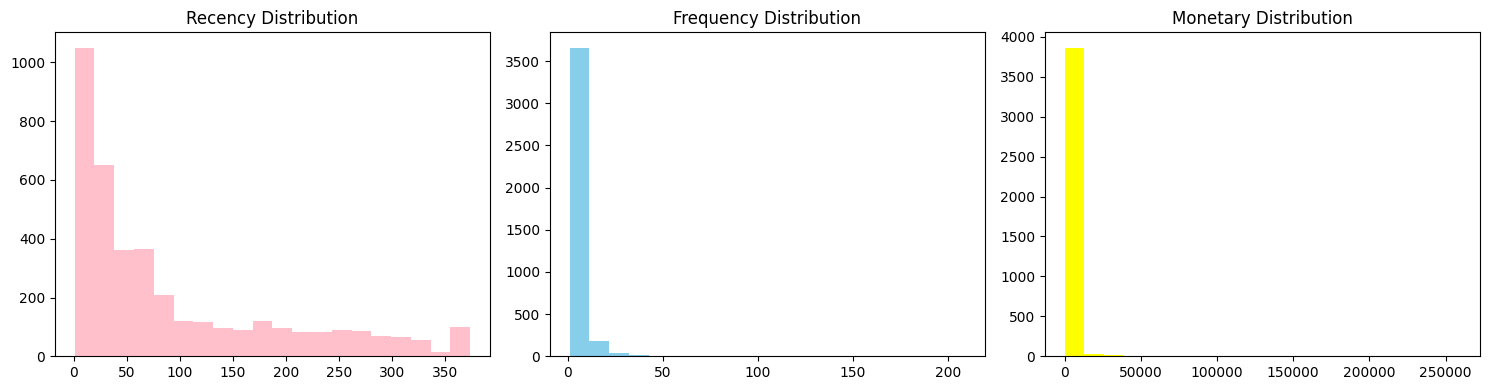

In [152]:
#hist

fig, axs=plt.subplots(1, 3, figsize=(15,4))
axs[0].hist(rfm['Recency'], bins=20, color='pink')
axs[0].set_title('Recency Distribution')

axs[1].hist(rfm['Frequency'], bins=20, color='skyblue')
axs[1].set_title('Frequency Distribution')

axs[2].hist(rfm['Monetary'], bins=20, color='yellow')
axs[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()

**Recency**: Most customers made a purchase recently and less haven't made a purchase in a long time.

**Frequency**: The majority of customers made a purchase once or thrice, while a few bought hundreds of times. (extremely right-skewed)

**Monetary**: Majority aren't big spenders, while a few are. (extremely right-skewed)

Because of the heavily skewed distribution, we will log transform the **Monetary** and **Frequency** then Standardize them all before employing K-Means(clustering).

## 4. Data Preprocessing for Clustering
Let's prepare data for the algorthims. The skewness will be handled by using Log transformation and scale features using Standardization

In [153]:
rfm_log=rfm.copy()

rfm_log['Frequency']=np.log1p(rfm_log['Frequency'])
rfm_log['Monetary']=np.log1p(rfm_log['Monetary'])

In [154]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
rfm_scaled=scaler.fit_transform(rfm_log[['Recency','Frequency','Monetary']])

#from numpy array back to dataframe
rfm_scaled=pd.DataFrame(rfm_scaled, columns=['Recency','Frequency','Monetary'])

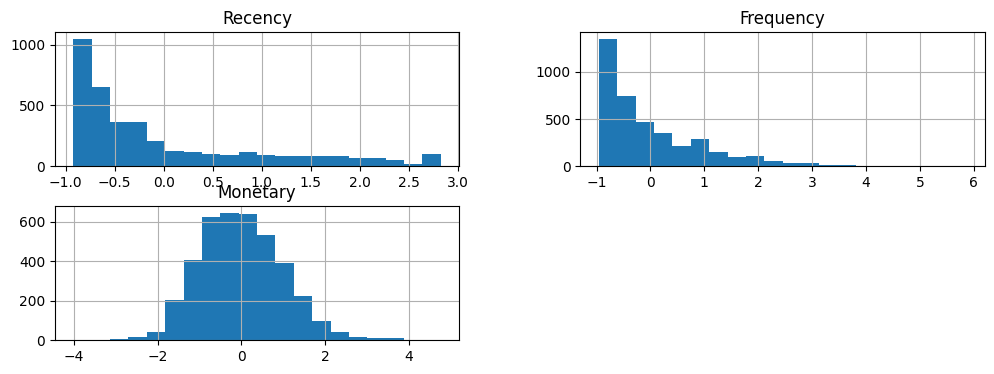

In [155]:
rfm_scaled.hist(bins=20, figsize=(12,4)) #to confirm balanced distribution
plt.show()

After log transformation and standardization, all three RFM features are centered around zero and the spread is balanced. Although the Frequency and Recency are still slightly skewed but clustering can handle it.

## 5. K-Means Clustering
K-means clustering will be used for the customer segmentation due to its suitability for numerical, continous variables such as Recency, Frequency, Monetary.

steps:
1. Selecting Optimal Number of Clusters (k)
2. Applying K-Means Model
3. Cluster Analysis & Interpretation

### **1. Selecting Optimal Number of Clusters (k)**
Two methods will be utilized to determine the number of clusters: 1) Elbow Method and 2) Silhuoette Score

For k=1, elbow methods inertia (WCSS) = 11760.00
For k=2, elbow methods inertia (WCSS) = 6157.86
For k=3, elbow methods inertia (WCSS) = 3846.82
For k=4, elbow methods inertia (WCSS) = 3456.18
For k=5, elbow methods inertia (WCSS) = 2517.32
For k=6, elbow methods inertia (WCSS) = 2114.41
For k=7, elbow methods inertia (WCSS) = 1914.24
For k=8, elbow methods inertia (WCSS) = 1789.51
For k=9, elbow methods inertia (WCSS) = 1607.12
For k=2, silhouette score = 0.4100
For k=3, silhouette score = 0.4165
For k=4, silhouette score = 0.3517
For k=5, silhouette score = 0.3605
For k=6, silhouette score = 0.3346
For k=7, silhouette score = 0.3029
For k=8, silhouette score = 0.2921
For k=9, silhouette score = 0.2954


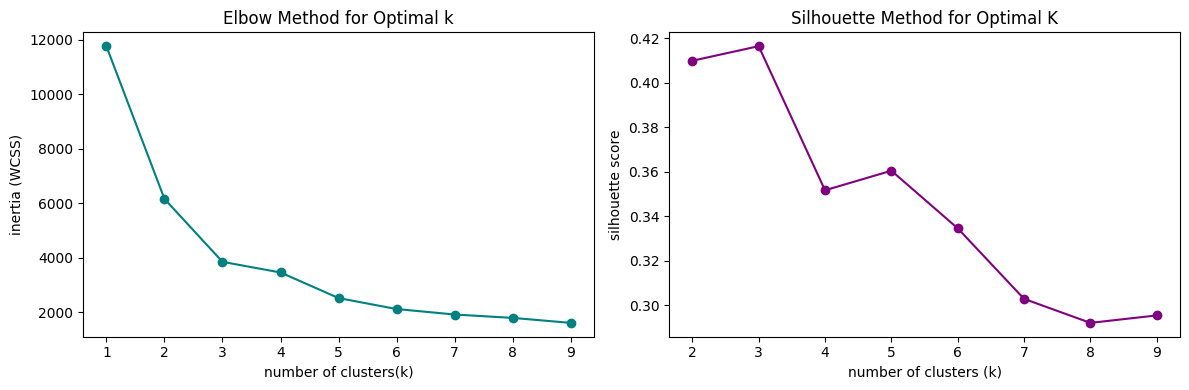

In [156]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X= rfm_scaled

#       1.Elbow Method
inertia=[]
K=range(1,10)

for k in K:
    kmeans=KMeans(n_clusters=k, random_state=13)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_) #save
    print(f'For k={k}, elbow methods inertia (WCSS) = {kmeans.inertia_:.2f}')
    
#       2.Silhouette score

silhouette_scores = []

K2=range(2,10)

for k in K2:
    kmean=KMeans(n_clusters=k, random_state=13)
    kmean.fit(X)
    score=silhouette_score(X, kmean.labels_)
    silhouette_scores.append(score)
    print(f'For k={k}, silhouette score = {score:.4f}')

#Plot
fig, ax=plt.subplots(1,2, figsize=(12,4))

#Elbow Plot: plot line graph k numbers against inertia (WCSS)
ax[0].plot(K, inertia, marker='o', color='teal')
ax[0].set_title('Elbow Method for Optimal k')
ax[0].set_xlabel('number of clusters(k)')
ax[0].set_ylabel('inertia (WCSS)')

#Silhouette Plot: plot cluster number (k) against silhouette score
ax[1].plot(K2, silhouette_scores, marker='o', color='purple')
ax[1].set_title('Silhouette Method for Optimal K')
ax[1].set_xlabel('number of clusters (k)')
ax[1].set_ylabel('silhouette score')

plt.tight_layout()
plt.show()

Elbow Method:
+ Big drop from k=1 to k=3, making elbow point at k=3
+ After k=3, the inertia decreases slowly
+ Thus, optimal **k = 3**

Silhouette Method:
+ Highest score is at k=3
+ Then it drops from there
+ Thus, optimal **k = 3**

Both methods agree that the number of clusters, **k = 3**

### **2. Applying K-Means Model**
The optimal number of clusters was determined using the Elbow and Silhouette methods. k=3. 
The K-Means algorithm will be applied to the standardized RFM dataset.

In [157]:
k_means=KMeans(init='k-means++', n_clusters=3, n_init=12) 
k_means.fit(X) 

,n_clusters,3
,init,'k-means++'
,n_init,12
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [158]:
labels=k_means.labels_ #extracts the cluster number assigned to each data point
labels

array([0, 0, 0, ..., 1, 0, 0], shape=(3920,), dtype=int32)

In [159]:
k_means_clusters_centers=k_means.cluster_centers_ #get coordinates of the centroids
k_means_clusters_centers

array([[-0.61825796,  1.19556747,  1.1201995 ],
       [-0.38018184, -0.42667874, -0.36309365],
       [ 1.61773596, -0.75107762, -0.77879511]])

In [160]:
#assign the labels back to the dataframe rfm (that contains the CustomerID and prior to the preprocessing)
rfm_final=rfm.copy()
rfm_final['Cluster']=labels
rfm_final.to_csv('rfm_final_clusters.csv', index=False) #saving it
rfm_final.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,326,1,77183.60,0
1,12747,3,11,4196.01,0
2,12748,1,209,33719.73,0
3,12749,4,5,4090.88,0
4,12820,4,4,942.34,1


### **3. Cluster Analysis & Visualization & Interpretation**
Now each cluster will be analyzed to reveal distinct customer segments and behavioral patterns

In [161]:
!pip install plotly
print('successfully installed')

successfully installed



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


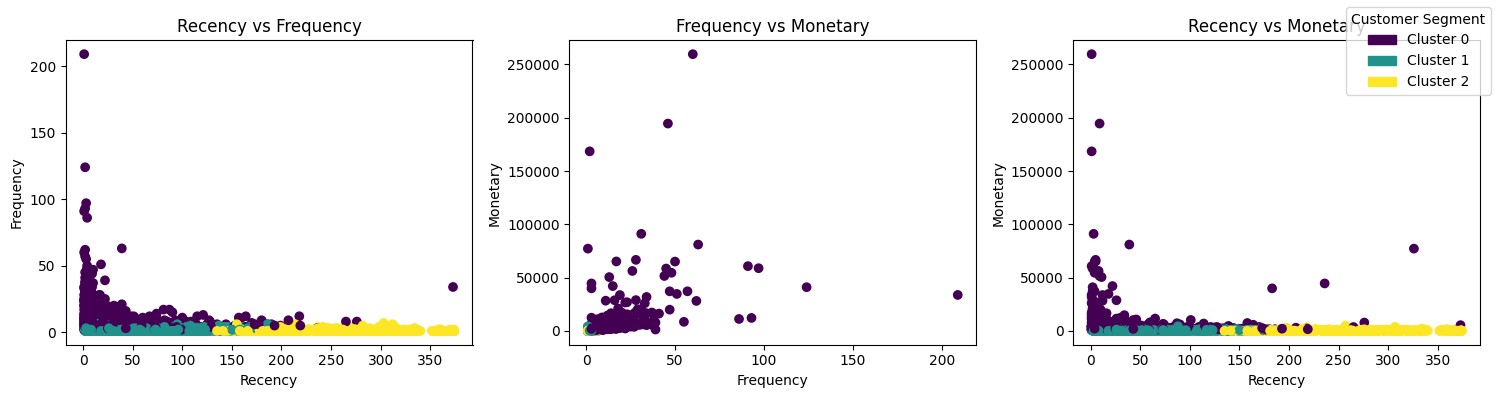

In [162]:
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

#visualize 
fig , ax= plt.subplots(1, 3, figsize=(15, 4))

#
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=rfm_final['Cluster'].min(),
                         vmax=rfm_final['Cluster'].max())

#Recency vs Frequency
ax[0].scatter(rfm_final['Recency'], rfm_final['Frequency'], c=rfm_final['Cluster'], cmap=cmap, norm=norm)
ax[0].set_title('Recency vs Frequency')
ax[0].set_xlabel('Recency')
ax[0].set_ylabel('Frequency')

#Frequency vs Monetary
ax[1].scatter(rfm_final['Frequency'], rfm_final['Monetary'], c=rfm_final['Cluster'], cmap=cmap, norm=norm)
ax[1].set_title('Frequency vs Monetary')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Monetary')

#Recency vs Monetary
ax[2].scatter(rfm_final['Recency'], rfm_final['Monetary'], c=rfm_final['Cluster'], cmap=cmap, norm=norm)
ax[2].set_title('Recency vs Monetary')
ax[2].set_xlabel('Recency')
ax[2].set_ylabel('Monetary')

#create& add legend
unique_clusters= np.sort(rfm_final['Cluster'].unique())
handles = [mpatches.Patch(color=cmap(norm(k)), label=f'Cluster {k}') for k in unique_clusters]
fig.legend(handles=handles, title='Customer Segment', loc='upper right')


plt.tight_layout()
plt.show()

Interpretation:
+ **Recency vs Frequency**
This graph demonstrates the relationship between customer's recent purchase and their purchase frequency. Cluster 0 (purple) is characterized by high frequency(purchased a lot) and low to medium recency (the majority are recent buyers). Cluster 1 (blue) is characterized with medium to the highest recency (haven't purchased for a while) and low frequency (they buy rarely). Cluster 2 (yellow) is charecterized with low to medium recency (relatively recent) and low frequency (purchase occasionally).

+ **Monetary vs Frequency**
This plot illustrates how often customer's buy and how much they spend. Cluster 0 appears to have the highest spenders. For better visualization, 3D plots will be used. 

+ **Recency vs Monetary**
This plot shows that customer's who purchased most recently (low recency) also tend to spend more. Cluster 0's purchase extends to very high monetary values. Cluster 1 and 2 are characterized by low Monetary values, not spending much.

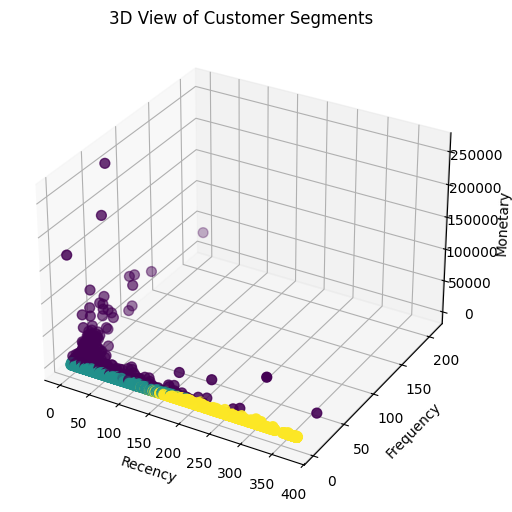

In [163]:
#3D visualization for better demonstration
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_final['Recency'], rfm_final['Frequency'], rfm_final['Monetary'], c=rfm_final['Cluster'], cmap='viridis', s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D View of Customer Segments')
plt.savefig('cluster_3d.png', dpi=300, bbox_inches='tight') #saving it

plt.show()


In [164]:
#further visualization

import plotly.express as px

# Create interactive 3D scatter plot
fig = px.scatter_3d(rfm_final, x='Recency', y='Frequency', z='Monetary',
                    color='Cluster', hover_data=['CustomerID'], opacity=0.7, color_continuous_scale='viridis', 
                    title='3D Interactive Customer Segmentation (RFM)')

# Customize look
fig.update_traces(marker=dict(size=4))
fig.update_layout(width=850, height=600,
                  scene_camera=dict(eye=dict(x=1.5, y=1.5, z=0.5)),
                  scene=dict(
                      xaxis_title='Recency', yaxis_title='Frequency', zaxis_title='Monetary'), 
                  coloraxis_showscale=False)


fig.show()


Interpretation:

The 3D plot integrates all RFM metrics, visually reinforcing that Cluster 0 forms a high-value group with low recency and high frequency/monetary values, while Cluster 1 and Cluster 2 are spread across lower value regions in both Frequency/Monetary (low spenders). Cluster 1 buyers purchased less recently than Cluster 2 buyers.

Let's confirm the visualizations **Quantitatively**

In [165]:
cluster_summary=rfm_final.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().round(2)
cluster_summary 

,Recency,Frequency,Monetary
Cluster,,,
0,31.16,9.69,4913.36
1,54.94,2.04,575.19
2,253.69,1.39,370.11


Interpretation:
+ Cluster 0:
    + Recency: 31 days = very recent
    + Frequency: 9.7 = shop very often
    + Monetary: 4922 = spend the most.

+ Cluster 1:
    + Recency = 253 days = haven’t bought in months.
    + Frequency = 1.4 = almost one-time buyers.
    + Monetary = 371 = very low spending.

+ Cluster 2:
    + Recency = 55 days = moderately recent
    + Frequency = 2.0 = occasional buyers
    + Monetary = 576 = low spenders

### **Conclusion** 
Overall, the RFM based clustering revealed three distinct groups of customers. 
1) Cluster 0: Loyal/Active High-value Customers
2) Cluster 1: Inactive or One-time-customers
3) Cluster 2: Occasional Customers

## 6. Behavioral, Psychological & Business Interpretation
Let's examine each cluste's RFM profile and make deduction on the type of shopper they represent.

### **Cluster 0** | **Loyal/Active High-value Customers**

| Metric   (average)             | Value            | Interpretation                |
| ---------------------- | ---------------- | ----------------------------- |
| Recency = 31 days      | Recently active  | Engaged |
| Frequency = 9.7       | High repeat rate | Habitual buyers               |
| Monetary = ≈ 4,922 GBP | High spending    | Strong lifetime value         |


**Psychological Profile:**
These are the behavioral loyalists, exhibiting consistent purchase patterns. This implies their strong commitment and high trust.

It is recommended to conduct qualitative methods such as Net Promoter Score (NPS) and Customer Satisfaction (CSAT) scores to determine whether they acquire a strong preferance and emotional/psychological connection for the brand, infering whether loyalty will be 

**Marketing Implication:**
To reinforce their loyalty, positive reinforcement must be given by rewarding them with exclusive perks, loyalty rewards program, and premium tiers.

### **Cluster 1** | **Inactive Low-Value Customers**

| Metric               | Value                  | Interpretation                |
| -------------------- | ---------------------- | ----------------------------- |
| Recency = 253 days   | Very inactive          | Possibly churned              |
| Frequency = 1.4     | Almost one-time buyers | Weak attachment               |
| Monetary = ≈ 371 GBP | Low value              | Price-sensitive or disengaged |


**Psychological Profile:**
These are one-time buyers or lost customers. Their behavior aligns with impulse buyers, making a purchase out of curiosity or spontaniety. 

**Marketing Implications:**
Discount emails & offers for price-sensitive customers. Upsell & cross-sell to increase revenue

### **Cluster 2** | **Occasional Customers**

| Metric               | Value             | Interpretation          |
| -------------------- | ----------------- | ----------------------- |
| Recency = 55 days    | Moderately recent | Still engaged           |
| Frequency = 2.0     | Occasional        | Balanced buying pattern |
| Monetary = ≈ 576 GBP | Mid spending      | Stable but not premium  |



**Psychological Profile:** 
These are casual buyers, or potential loyalists. They shop occasionally and despite their habits of buying aren't strong yet, they're reachable. Behaviorally, it is implied that they are satisficers, they might seem like they are committed to this brand but they lack emotional brand connection. To turn them to loyal customers, one must make their customer experience consistently reliable and efficient. emotionally satisfying

**Marketing Implications:**
Send personalized offers, gamified incentives, acquiring points for repeated purchases.

## 7. Visualization & Storytelling
To represent the results clearly, we'll visualize the findings using heatmaps and bar plot.

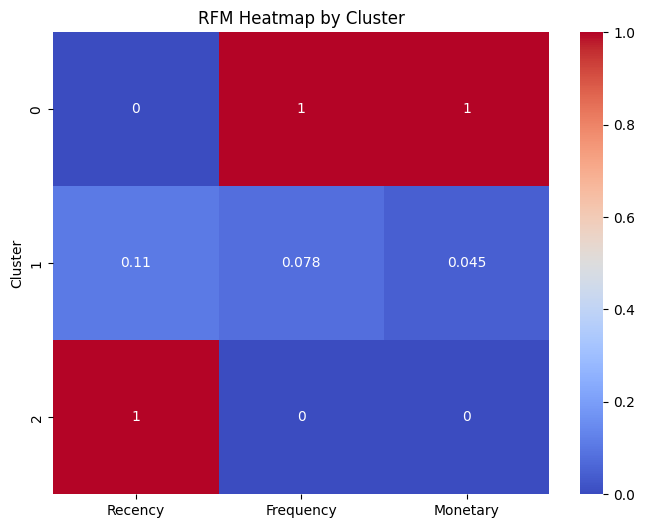

In [166]:
#lets normalize so all data are on same 1-0 scale
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
normalized=scaler.fit_transform(cluster_summary)

cluster_sum_norm=pd.DataFrame(normalized, index=cluster_summary.index, columns=cluster_summary.columns)

#heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cluster_sum_norm, annot=True, cmap='coolwarm')
plt.title('RFM Heatmap by Cluster')
plt.savefig('cluster_heatmap.png', dpi=300, bbox_inches='tight') #saving it
plt.show()

The heatmap provides a normalized comparison of the three RFM metrics across clusters.
It visually confirms the distinctions identified earlier:

+ Cluster 0 shows low recency and high frequency and monetary values, confirming these as the loyal/high-value customers.

+ Cluster 1 displays high recency and low frequency/monetary, representing inactive or at-risk customers.

+ Cluster 2 remains moderate across all dimensions, indicating potential loyalists or regular buyers.

This visualization reinforces the earlier interpretation, showing a clear behavioral separation between customer groups.

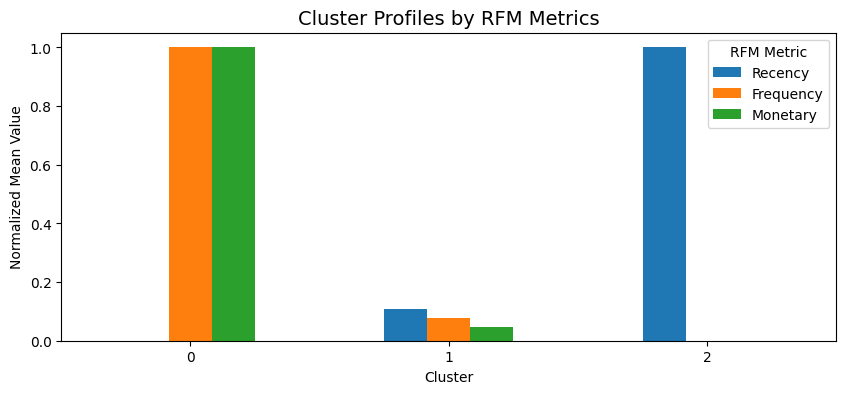

In [167]:
#bar chart

cluster_sum_norm.plot(kind='bar', figsize=(10,4))
plt.title('Cluster Profiles by RFM Metrics', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Normalized Mean Value')
plt.xticks(rotation=0)
plt.legend(title='RFM Metric')
plt.show()


Overall, the normalized bar chart reinforces the segmentation patterns found in the heatmap, but emphasizes the proportional differences among metrics within each cluster. It visually highlights where each segment performs strongest or weakest, guiding targeted marketing or retention strategies.

## 8. Conclusion
To conclude, this project aimed to segment online retail customers based on their purchasing behavior using RFM (Recency, Frequency, Monetary) analysis and K-Means clustering. After extensive data cleaning, feature engineering, and standardization, the optimal number of clusters was determined to be k = 3 using the Elbow and Silhouette methods.

The clustering results revealed three distinct customer segments, as illustrated below:

| Cluster | Recency | Frequency | Monetary | Customer Type                | Insight                                                   |
| ------- | ------- | --------- | -------- | ---------------------------- | --------------------------------------------------------- |
| 0       | Low     | High      | High     | **Loyal / High-value Customers**    | Frequent, recent, and high-spending buyers.               |
| 1       | High    | Low       | Low      | **Inactive / Low-value Customers** | Haven’t purchased recently; minimal engagement.           |
| 2       | Medium  | Medium  | Medium   | **Occasional Customers**      | Potential Loyalists; can be nurtured with retention offers. |


From a business perspective, these insights enable targeted marketing strategies, as demonstrated below:

### **Actionable recommendations**
| **Cluster** | **Customer Type**      | **Key Strategy** | **Action**                                                |
| ----------- | ---------------------- | ---------------- | --------------------------------------------------------- |
| **0**       | Loyal / High-Value     | Retain & Reward  | Loyalty programs, VIP perks           |
| **1**       | Inactive / Low-Value   | Reactivate       | Win-back emails, time-limited discounts      |
| **2**       | Occasional / Mid-Value | Engage & Grow    | Personalized offers, cross-sell bundles, gamified rewards |



These insights can directly support data-driven marketing strategists aimed at enhance customer engagement and profitability.

In future work, additional features such as product categories or seasonal behavior could enhance segmentation. Exploring advanced models like hierarchical clustering may also reveal finer behavioral subgroups.




----